# Coupled memristors Evolution and Form Factor

In this code we calculate the evolution of two coupled quantum memristors given by:  

**Phys. Rev. A 104, 062605 (2021)**

and calculate the form factor of the resulting hysteresis curve.

## Theory

A system of two quantum memristors coupled by a capacitor and an inductor is described by:
$$
\hat{H} = \sum_{\ell = 1}^{2} E_{C_{\ell, \ell}}\hat{n}_{\ell}^{2} + \frac{E_{L_{\ell, \ell}}}{2}\hat{\varphi}_{\ell}^{2} + E_{C_{1,2}} \hat{n}_{1} \hat{n}_{2} + E_{L_{1,2}} \hat{\varphi}_{1} \hat{\varphi}_{2}
$$
where:
- $\hat{n}_{\ell}$ is the number of cooper pairs operator for memristor $\ell$.
- $ \hat{\varphi}_{\ell}$ is the phase operator for memristor $\ell$. 
- $E_{C} = 2e^{2} \hat{C}^{-1}$ is the charge energy matrix.
- $\hat{C}^{-1}$ is the inverse of the capacitance matrix. 
- $E_{L} = \varphi_{0}^{2} \hat{L}^{-1}$ is the inductive energy matrix.
- $\varphi_{d} = \phi_{d}/\varphi_{0}$ is the time-dependent external phase. 
- $\varphi_{0} = \hbar/2e$ is the reduced flux quantum.

In the Fock basis, this is

$$
H = \hbar \sum_{\ell = 1}^{2} \omega_{\ell} a_{\ell}^{\dagger}a_{\ell} - \sqrt{\omega_{1} \omega_{2}} (\alpha - \beta)(a_{1}^{\dagger} a_{2} + a_{2}^{\dagger} a_{1})
$$
Here,
- $\omega_{\ell} = \sqrt{2 E_{C_{\ell, \ell}} E_{L_{\ell, \ell}}}/\hbar$  is the frequency of memristor $\ell$.

- $\alpha = \frac{E_{L_{1, 2}}}{ \sqrt{E_{L_1} E_{L_2}} }$.

- $\beta = \frac{E_{C_{1, 2}}}{ \sqrt{E_{C_1} E_{C_2}} }$.

Additionally we have
$$
\hat{n}_{\ell} = \frac{i}{4g_{\ell}}(\hat{a}_{\ell}^{\dagger} - \hat{a}_{\ell}) \\
\hat{\varphi}_{\ell} = 2g_{\ell}(\hat{a}_{\ell}^{\dagger} + \hat{a}_{\ell})
$$

with $g_{\ell} = \big(E_{C_{\ell, \ell}}/ 32 E_{L_{\ell, \ell}}  \big)^{1/4}$.


The system undergoes quasiparticle decay, described by the master equation
$$
\dot{\rho}(t) = -\frac{i}{\hbar}\big[\hat{H}, \rho \big] + \sum_{\ell} \frac{\Gamma_{\ell}(t)}{2} \bigg(\hat{a}_{\ell}\rho \hat{a}_{\ell}^{\dagger} - \frac{1}{2}\{\hat{a}_{\ell}^{\dagger}\hat{a}_{\ell}, \rho \} \bigg)
$$
where 
- $\Gamma_{\ell}(t) = g_{\ell}^{2}e^{-g_{\ell}^{2}} \bigg(\frac{1 + \cos\big(\phi_{d_{\ell}}(t)/2\big)}{2} \bigg)S_{\textrm{qp}}(\omega_{\ell})$, is the time dependent decay rate for each subsystem.
- $\phi_{d_{\ell}}(t) = \phi_{0, \ell} + A \sin(\omega_{\ell} t)$, is the external flux in the SQUID.
- $S_{\textrm{qp}}(\omega_{\ell}) = \omega_{\ell}$ is the spectral density. 

The quasiparticle current $\hat{I}_{\textrm{qp}}$ and the voltage across the capacitor $\hat{V}_{\textrm{cap}}$ are the quantities that show memristive dynamics, they can be obtained from the equations of motion of $\hat{n}$ and $\hat{\varphi}$. The memristive relation is given by

$$
\begin{aligned}
\hat{I}_{\textrm{qp}, \ell} &= G_{\ell}(t) \hat{V}_{\textrm{cap}, \ell} \\
\hat{V}_{\textrm{cap}, \ell} &= -2e\langle \hat{n}\rangle/C_{\Sigma, \ell}
\end{aligned}
$$

with $G_{\ell}(t) = \frac{g_{\ell}^{2}e^{-g_{\ell}^{2}}C_{\Sigma, \ell} S_{\textrm{qp}, \ell}(\omega_{\ell})}{4} \bigg(1 + \cos\big(\frac{\phi_{d_{\ell}}(t)}{2}\big) \bigg)$.


Finally, the coupled system must satisfy the two-level approximation for each quantum memristor, we can ensure this by limiting the total excitation number to 1, and consider only product states

$$
\vert \psi (t) \rangle = \vert \psi_{1} (t) \rangle \vert \psi_{2} (t) \rangle
$$

and $\vert \psi_{n} (t) \rangle = \cos(\theta_{n} / 2) \vert 0 \rangle + e^{i \eta_{n}} \sin(\theta_{n}/2) \vert 1 \rangle$. with:

$$
\theta_{1} = 2\arcsin (\cos(\theta_{2}/2))
$$

We calculate the form factor for the hysteresis curves that are drawn in the $\hat{I}_{\textrm{qp}}$-$\hat{V}_{\textrm{cap}}$ plot. The form factor involves calculating the area and perimeter of a closed figure, so it can only be calculated at certain times where hysteresis curve closes on itself. The form factor is given by 
$$
F = 4\pi\frac{A}{P^{2}}
$$


# Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
import qutip as qp
import time
import pickle


# System Parameters

In [4]:
# =============================================================================
# System Parameters
# =============================================================================
""" Fundamental constants"""
hbar = 1.054571 * 1e-34  # Planck constant [J x s]
phi0 = 2.067833 * 1e-15/(2*np.pi)  # Magnetic Flux quantum [Wb]
G0 = 7.748091 * 1e-5  # Conductance quantum [Siemens]
e = 1.602176 * 1e-19 # electron charge [C]


# Coupled memristor evolution function

In [5]:
def Coupled_memristor_evolution(theta_1 = 1, theta_2 = 1, lambda_ = 1, C12 = 0, L12 = 0):
    # Based on the reference, the Capacitive energy is 1Ghz, and the
    # Inductive energy is 1000 times the capacitive energy. 
    # We choose the parameters corresponding to this condition
    C1 = 4.868269*1e-13  # Effective SQUID capacitance [Farad] => Cg = 2*(e**2)/(1e9*hbar)
    C2 = 4.868269*1e-13  # Effective SQUID capacitance [Farad] => Cg = 2*(e**2)/(1e9*hbar)
    L1 = 1.027059*1e-9  # Inductance of outer loop [Henry]
    L2 = 1.027059*1e-9  # Inductance of outer loop [Henry]
    
    "Here we use C12, L12 arguments"
    if C12 is not 0:
        # Capacitance matrix
        C = np.array([ [C1 + C12, -C12], 
                       [-C12, C2 + C12] ])
        EC12 = 2*(e**2)*C12       # charging energy of capacitive coupling
    else:
        C = np.array([ [C1 , 0], 
                       [0, C2] ])
        EC12 = 0
    # Inverse of capacitance matrix
    C_inv = np.linalg.inv(C)

    if L12 is not 0:
        # inductance matrix
        L = np.array([ [1/L1 + 1/L12, -1/L12], 
                       [-1/L12, 1/L2 + 1/L12] ])
        EL12 = (phi0**2)/L12      # Inductive energy of inductive coupling
    else:
        L = np.array([ [1/L1, 0], 
                       [0, 1/L2] ])
        EL12 = 0


    EC1 = 2*(e**2)*C_inv[0,0]  # Charging energy of capacitor of memristor 1
    EC2 = 2*(e**2)*C_inv[1,1]   # Charging energy of capacitor of memristor 2

    EL1 = (phi0**2) * L[0,0]    # Inductive energy of inductor of memristor 1
    EL2 = (phi0**2) * L[1,1]    # Inductive energy of inductor of memristor 2
    

    g1 = (EC1/(32*EL1))**(1/4) # Constant relevant for n and phi operators
    g2 = (EC2/(32*EL2))**(1/4) # Constant relevant for n and phi operators
    omega1 = np.sqrt(2*EC1*EL1)/(1e9*hbar) # Frequency of the harmonic oscillator of memristor 1, in units of GHz
    omega2 = np.sqrt(2*EC2*EL2)/(1e9*hbar) # Frequency of the harmonic oscillator of memristor 2, in units of GHz
    
    "Here we use s_cte argument"
    s_w1 = lambda_ * omega1  # Spectral density  of environment
    s_w2 = lambda_ * omega2  # Spectral density  of environment

    alpha = EL12/np.sqrt(EL1*EL2)
    beta = EC12/np.sqrt(EC1*EC2)
    dim = 2  # Number of excitations in the harmonic oscillator

    phi0_1 = np.pi/2
    phi0_2 = np.pi/2
    A_1 = 1
    A_2 = 1

    k = np.sqrt(omega1*omega2)*(alpha + beta)

    # =============================================================================
    # Operators and decay
    # =============================================================================
    """ Define the operators and Hamiltonian of the system """
    I = qp.qeye(dim)     # Identity
    a1 = qp.tensor(qp.destroy(dim), I)  # Annihilation operator for memristor 1
    a2 = qp.tensor(I, qp.destroy(dim))  # Annihilation operator for memristor 2
    H = omega1*a1.dag()*a1 + omega2*a2.dag()*a2 + k*(a1.dag()*a2 + a1*a2.dag())  # Coupled memristors Hamiltonian
 
    n1 = (1j/(4*g1))*(a1.dag() - a1) # Number of Cooper pairs operator for memristor 1
    n2 = (1j/(4*g2))*(a2.dag() - a2) # Number of Cooper pairs operator for memristor 2
    phi1 = 2*g1*(a1.dag() + a1)   # Phase operator for memristor 1
    phi2 = 2*g2*(a2.dag() + a2)   # Phase operator for memristor 2

    "Initial State"
    "Here we use theta_1, theta_2 arguments"
    psi_1 = np.cos(theta_1[0]/2)*qp.fock(dim,0) + np.exp(1j*theta_1[1])*np.sin(theta_1[0]/2) * qp.fock(dim, 1) 
    psi_2 = np.cos(theta_2[0]/2)*qp.fock(dim,0) + np.exp(1j*theta_2[1])*np.sin(theta_2[0]/2) * qp.fock(dim, 1) 
    
    psi_0 = qp.tensor(psi_1, psi_2)

    """ Define the time dependent decay rate """
    params = {'g1':g1, 'g2':g2, 'omega1':omega1, 'omega2':omega2, 's_w1':s_w1, 's_w2':s_w2}

    def gamma1(t,args):
        g1 = args['g1']     # import g1 into function namespace
        s_w1 = args['s_w1'] # import s_w1 into function namespace   
        phi_ini = np.pi/2  # phase shift of external flux
        phid = phi_ini + np.sin(omega1*t)  # external flux
        gamma_0 = 0.25*g1**2 * np.exp(-g1**2) * s_w1   # bare decay rate
        gamma_T = np.sqrt(gamma_0 * (1 + np.cos(phid)))  # We take square root because master equation solver squares the decay rate

        return gamma_T
              
    def gamma2(t,args):
        g2 = args['g2']     # import g1 into function namespace
        s_w2 = args['s_w2'] # import s_w1 into function namespace   
        phi_ini = np.pi/2  # phase shift of external flux
        phid = phi_ini + np.sin(omega2*t)  # external flux
        gamma_0 = 0.25*g2**2 * np.exp(-g2**2) * s_w2   # bare decay rate
        gamma_T = np.sqrt(gamma_0 * (1 + np.cos(phid)))  # We take square root because master equation solver squares the decay rate

        return gamma_T
              
    "Collapse operators"
    c_ops = [ [a1, gamma1], [a2, gamma2] ]  # time-dependent collapse operators

    # =============================================================================
    # System Dynamics
    # =============================================================================
    """ Dynamics parameters """
    number_oscillations = 5
    points_per_oscillation = 500
    time_points = number_oscillations * points_per_oscillation
    "Timescale should be chosen carefully"          
    timescale = 2*np.pi/(omega1)  # Period of the oscillator
    t = timescale * np.linspace(0, number_oscillations, time_points) # Time vector for our time evolution

    rho_t = qp.mesolve(H, psi_0, t, c_ops, args=params)  # Solve master equation

    V1 = np.zeros(len(t))  # Voltage vector for mem 1
    V2 = np.zeros(len(t))  # Voltage vector for mem 2
    P1 = np.zeros(len(t))  # Phase vector for mem 1
    P2 = np.zeros(len(t))  # Phase vector for mem 2
    Iqp1 = np.zeros(len(t))  # Quasiparticle current vector for mem 1
    Iqp2 = np.zeros(len(t))  # Quasiparticle current vector for mem 2

    for index, state in enumerate(rho_t.states):
        V1[index] = -2*e*qp.expect(n1, state)/C1    # Voltage for mem 1
        V2[index] = -2*e*qp.expect(n2, state)/C2    # Voltage for mem 2
        P1[index] = qp.expect(phi1, state)   # Phase for mem 1
        P2[index] = qp.expect(phi2, state)   # Phase for mem 2  
        Iqp1[index] = (gamma1(t[index], params)**2) * (V1[index]*C1)   # Quasiparticle Current for mem 1
        Iqp2[index] = (gamma2(t[index], params)**2) * (V2[index]*C2)   # Quasiparticle Current for mem 2
        
    """ Define maximum initial voltage and quasiparticle current """
    psi1_max_volt = np.cos(np.pi/4)*qp.fock(dim, 0) + np.exp(1j*np.pi/2)*np.sin(np.pi/4) * qp.fock(dim, 1)               
    psi2_max_volt = np.cos(np.pi/4)*qp.fock(dim, 0) + np.exp(1j*np.pi/2)*np.sin(np.pi/4) * qp.fock(dim, 1) 
    psi_max = qp.tensor(psi1_max_volt, psi2_max_volt)
    
    V1_0 = -2*e*qp.expect(n1, psi_max)/C1  # Normalizing voltage constant for mem 1
    V2_0 = -2*e*qp.expect(n2, psi_max)/C2  # Normalizing voltage constant for mem 2          
    I1_0 = V1_0*(gamma1(0, params)**2)*C1     # Normalizing quasiparticle current constant for mem 1
    I2_0 = V2_0*(gamma2(0, params)**2)*C2     # Normalizing quasiparticle current constant for mem 2
    
    # =============================================================================
    # Auxiliary functions
    # =============================================================================

    def Identify_loops(x,y):
        """
        This function stores the indices of the point in time
        when x crosses zero value, and stores them in the indices
        container.

        One memristive hysteresis curve crosses the origin two times during its entire loop
        So the indices that denote the starting point of each hysteresis curve are obtained
        by taking every other element from indices container.
        This is stored in the real_indices container.
        """
        indices = []
        real_indices = []
        for ind in range(len(x)-1):
            prod_sign = np.sign(x[ind]*x[ind+1])
            if prod_sign == -1:
                closest_ind = np.argmin(np.abs([x[ind], x[ind+1]])) # Choose which point is closer to zero n or n+1
                if closest_ind == 0:
                    indices.append(ind)
                else:
                    indices.append(ind+1)

        for n in range(int(len(indices)/2) ):
            real_indices.append(indices[2*n])  
        return real_indices  # 

    def Area(x,y):
        "Area is calculated with Green's theorem"
        A = 0
        for i in range(len(x)-1):
            A += 0.5*abs(y[i]*(x[i+1]-x[i]) - x[i]*(y[i+1]-y[i]))
        return A

    def Perimeter(x,y):
        L = 0
        for i in range(len(x)-1):
            L += np.sqrt((x[i+1] - x[i])**2 + (y[i+1] - y[i])**2)
        return L

    # =============================================================================
    # Form Factor
    # =============================================================================
    def Form_factor(x,y):
        indices = Identify_loops(x,y)
        number_of_loops = len(indices)-1
        form_factor = np.zeros([number_of_loops])

        for n in range(number_of_loops):
            loop_x = x[indices[n]:indices[n+1]]
            loop_y = y[indices[n]:indices[n+1]]
            form_factor[n] = 4*np.pi*Area(loop_x,loop_y)/(Perimeter(loop_x,loop_y)**2)

        return form_factor


    # =============================================================================
    # Calculate Form Factor for current Dynamics
    # =============================================================================

    FF1 = Form_factor(V1/V1_0, Iqp1/I1_0) # Form factor for normalized current and voltage
    FF2 = Form_factor(V2/V2_0, Iqp2/I2_0) # Form factor for normalized current and voltage
    ff1 = np.mean(FF1)
    ff2 = np.mean(FF2)
    
    FF = [ff1, ff2]
    V = [V1, V2]
    Iqp = [Iqp1, Iqp2]
    
    indices = Identify_loops(V1/V1_0,Iqp1/I1_0)  # indices of points in time when a full loop is completed
    
    parameters = {'omega1':omega1, 'omega2':omega2, 'V1_0':V1_0, 'I1_0':I1_0, 
                  'V2_0':V2_0, 'I2_0':I2_0, 'timescale':timescale} 
    
    Results = [FF, V, Iqp]
    Parameters = [t, indices, parameters]
              
    return Results, Parameters

# Coupled Memristor evolution for random parameters

In [6]:
""" System Parameters """ 
"Range of values for theta, alpha, C12 and L12"
t1 = time.perf_counter()

theta_min = 0.01
theta_max = 0.99*2*np.pi

lambda_min = 0.1
lambda_max = 100

C12_min = 0           # minimum value for capacitive coupling
C12_max = 20 * 1e-13  # maximum value for capacitive coupling

L12_min = 0           # minimum value for inductive coupling
L12_max = 20 * 1e-9   # maximum value for inductive coupling


"Preallocation"
n_samples = 5000
Data_dtype = np.dtype([('C12', np.float32),
                       ('L12', np.float32),
                       ('theta', np.float32),
                       ('lambda_', np.float32),
                       ('Formfactor_1', np.float32),
                       ('Formfactor_2', np.float32)])

Data = np.zeros(n_samples, dtype = Data_dtype)

Time = []
V = []
Iqp = []

omega1 = np.zeros(n_samples)
omega2 = np.zeros(n_samples)
I1_0 = np.zeros(n_samples)
I2_0 = np.zeros(n_samples)
V1_0 = np.zeros(n_samples)
V2_0 = np.zeros(n_samples)
timescale = np.zeros(n_samples)

t_loop = 0
for k1 in range(n_samples):
    t_loop_1 = time.perf_counter()
    C12 = np.random.uniform(low = C12_min, high = C12_max)
    L12 = np.random.uniform(low = L12_min, high = L12_max)
    theta = np.random.uniform(low = theta_min, high = theta_max)
    lambda_ = np.random.uniform(low = lambda_min, high = lambda_max)
    
    theta1 = [np.pi/2, theta]
    theta2 = [np.pi/2, theta]
    
    Results, Parameters = Coupled_memristor_evolution(theta_1 = theta1, theta_2 = theta2, lambda_ = lambda_,
                                                       C12 = C12, L12 = L12)
    
    FF, V_aux, Iqp_aux = Results
    t, indices, parameters = Parameters
    Data['C12'][k1] = C12
    Data['L12'][k1] = L12
    Data['theta'][k1] = theta
    Data['lambda_'][k1] = lambda_
    Data['Formfactor_1'][k1] = FF[0]
    Data['Formfactor_2'][k1] = FF[1]
    V.append(V_aux)
    Iqp.append(Iqp_aux)
    Time.append

    omega1[k1] = parameters['omega1']
    omega2[k1] = parameters['omega2']
    I1_0[k1] = parameters['I1_0']
    I2_0[k1] = parameters['I2_0']
    V1_0[k1] = parameters['V1_0']
    V2_0[k1] = parameters['V2_0']
    timescale[k1] = parameters['timescale']
        
    
    t_loop_2 = time.perf_counter()
    t_loop += (t_loop_2 - t_loop_1)
    m_tloop = t_loop/(k1 + 1)
    remaining_time = m_tloop * (n_samples - k1)
    
    print('k1 = ', k1)
    print(f'mean time per iteration = {m_tloop:.4f}', f' expected remaining time {remaining_time/60:.4f} min', end='\x1b[1K\r')
    print('----')
    


t2 = time.perf_counter()

print(f'duration = {(t2-t1):.4f} s, or {(t2-t1)/60:.4f} min')
    
    
    


k1 =  0
---- time per iteration = 0.3302  expected remaining time 27.5186 min
k1 =  1
---- time per iteration = 0.2863  expected remaining time 23.8533 min
k1 =  2
---- time per iteration = 0.2717  expected remaining time 22.6342 min
k1 =  3
---- time per iteration = 0.2623  expected remaining time 21.8456 min
k1 =  4
---- time per iteration = 0.2536  expected remaining time 21.1156 min
k1 =  5
---- time per iteration = 0.2509  expected remaining time 20.8840 min
k1 =  6
---- time per iteration = 0.2510  expected remaining time 20.8894 min
k1 =  7
---- time per iteration = 0.2649  expected remaining time 22.0414 min
k1 =  8
---- time per iteration = 0.2649  expected remaining time 22.0430 min
k1 =  9
---- time per iteration = 0.2661  expected remaining time 22.1384 min


KeyboardInterrupt: 

# Save Data

In [11]:
Info = ['We calculate the form factor for a system of two coupled quantum memristors by capacitive and inductive coupling',
        'We consider 5000 instances of randomly varying 4 parameters C12, L12, theta, lambda_',
        'Additionally we store a list of Voltage, V, and quasiparticle current, Iqp as a function of time for each subsystem',
        'Each of these 2 lists contain 5000 elements, each element is an array with the values of V and Iqp in time',
        'the "time" variable is the time series array corresponding to the evolution, it is the same for all cases'
        'Finally the parameters variable, stores additional parameters that may be important',
        'These are omega1, omega2, I1_0, I2_0, V1_0, V2_0 and timescale'
       ]

# with open('Coupled_memristors_formfactor.dat', 'wb') as arg:
#     pickle.dump([Data, V, Iqp, Time, parameters, Info], arg)

In [10]:
type(time)

module

### Plots

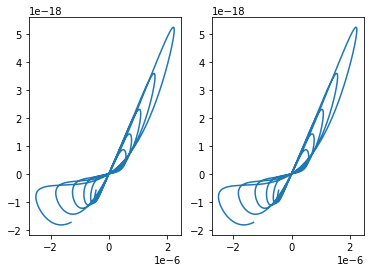

In [20]:
fig1 = plt.figure(1)

random_case = 600

ax11 = fig1.add_subplot(1,2,1)
ax12 = fig1.add_subplot(1,2,2)

ax11.plot(V[random_case][0], Iqp[random_case][0])
ax12.plot(V[random_case][1], Iqp[random_case][1])
